# Titanic - Machine Learning from Disaster

<img src="https://www.kaggle.com/competitions/3136/images/header" width=900>

- Vamos utilizar os [dados disponíveis no Kaggle](https://www.kaggle.com/competitions/titanic)
    - É um dataset de **competição**
    - O resultado é avaliado através da **acurácia**:
        - _"Sua pontuação é a porcentagem de passageiros que você prevê corretamente. Isso é conhecido como acurácia."_

### Começando a entender a base

- **Podemos utilizar o ydata-profiling (antigo Pandas Profiling) para começar a entender essa base**
    - https://github.com/ydataai/ydata-profiling

In [197]:
# Importando Pandas
import pandas as pd

In [198]:
# Visualizando dataset
treino = pd.read_csv("train.csv")
treino.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [199]:
# Usando uma ferramenta para explorar os dados de forma geral e de uma só vez
from ydata_profiling import ProfileReport
profile = ProfileReport(treino, title="Titanic_Train_Report")

In [200]:
# Gerando um report 
# profile.to_file("Titanic_Train_Report.html")

In [201]:
# Verificando as informações da base
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [202]:
# Verificando as informações da base de treino
treino.dtypes.value_counts()

int64      5
object     5
float64    2
Name: count, dtype: int64

In [203]:
# Verificando os valores nulos
treino.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [204]:
# Importando a base de teste
teste = pd.read_csv("test.csv")
teste.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [205]:
# Verificando as informações da base de treino
teste.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

* Percebemos discrepância de dados ausentes entre as bases. Na base de treino há dados ausentes diferentes da base de teste. Ou seja, temos colunas que possuem valores vazinos na base de teste que não estão vazias na base de treino ("Fare", por exemplo). Precisamos tratar as bases.

### Tratamentos iniciais

* Tratando valores vazios

In [206]:
# Verificando novamente os valores ausentes em Treino
treino.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [207]:
# De 891 linhas, temos 687 missing values para coluna "Cabin"
treino.shape

(891, 12)

* As colunas "PassengerId", "Ticket", "Cabin", e "Name", apresentam alta cardinalidade (alta quantidade de valores distintos), além de algumas serem strings. Isso dificulta o processamento dos dados pelo modelo pois não favorece a generalização buscada por ele. Portanto, descartaremos tais colunas.

In [208]:
# Cardinalida
treino.nunique().sort_values(ascending=False)

PassengerId    891
Name           891
Ticket         681
Fare           248
Cabin          147
Age             88
SibSp            7
Parch            7
Pclass           3
Embarked         3
Survived         2
Sex              2
dtype: int64

In [209]:
# Eliminando algumas colunas em ambos datasets 
treino = treino.drop(["Name", "Ticket", "Cabin"], axis=1)
teste = teste.drop(["Name", "Ticket", "Cabin"], axis=1)

* Precisamos tratar os NaN values na coluna "Age" pois todos os passajeiros tinham algum valor de idade. Usaremos a média como substituição.

In [210]:
# Verificando a média de idade
treino["Age"].mean()

29.69911764705882

In [211]:
# Selecionando as linhas com idade vazia e substituindo pela média
treino.loc[treino["Age"].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,6,0,3,male,NaN,0,0,8.4583,Q
17,18,1,2,male,NaN,0,0,13.0000,S
19,20,1,3,female,NaN,0,0,7.2250,C
26,27,0,3,male,NaN,0,0,7.2250,C
28,29,1,3,female,NaN,0,0,7.8792,Q
...,...,...,...,...,...,...,...,...,...
859,860,0,3,male,NaN,0,0,7.2292,C
863,864,0,3,female,NaN,8,2,69.5500,S
868,869,0,3,male,NaN,0,0,9.5000,S
878,879,0,3,male,NaN,0,0,7.8958,S


In [212]:
# Substituindo NaN values pela média
treino.loc[treino["Age"].isnull(),"Age"] = treino["Age"].mean()
teste.loc[teste["Age"].isnull(),"Age"] = teste["Age"].mean()

* Constatamos que há 2 missing values na coluna "Embarked" e o valor mais frequente é "S". Faremos o tratamento através da substituição pela moda.

In [213]:
treino.loc[treino["Embarked"].isnull(),"Embarked"]

61     NaN
829    NaN
Name: Embarked, dtype: object

In [214]:
treino["Embarked"].mode()[0]

'S'

In [215]:
#Substituindo valores pela moda 
treino.loc[treino["Embarked"].isnull(),"Embarked"] = treino["Embarked"].mode()[0]

* Constatamos também que há 1 missing values na coluna "Fare" para a base de teste. Faremos o tratamento através da substituição pela média.

In [216]:
teste.loc[teste["Fare"].isnull(),"Fare"]

152   NaN
Name: Fare, dtype: float64

In [217]:
# Substituindo pela média
teste.loc[teste["Fare"].isnull(),"Fare"] = teste["Fare"].mean()

* Verificando se ainda existem NaN values em ambos datasets

In [218]:
treino.isnull().sum().sort_values(ascending=False)

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [219]:
teste.isnull().sum().sort_values(ascending=False)

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

--- 
* Tratamos valores ausente pela média e moda de acordo com os conceitos estatísticos; eliminamos as colunas que não ajudariam na análise; deixamos a coluna ID pois será necessária para a submissão na plataforma Kaggle (removeremos antes do teste).

### Considerando apenas as colunas que não são texto para importação nos modelos

In [220]:
# Verificando as colunas de valores numéricos na base de treino 
treino.columns[treino.dtypes != "object"]

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [221]:
# Selecionando as linhas cujas as colunas contém apenas valores numéricos, na base treino
treino_nr = treino.loc[:,treino.columns[treino.dtypes != "object"]]

In [222]:
# Selecionando apenas as colunas com valores numéricos na base teste
teste_nr = teste.loc[:,teste.columns[teste.dtypes != "object"]]

#### Podemos, agora, selecionar um modelo para classificar esses dados
* Vamos utilizar os seguintes modelos:
    * Árvore de classificação (https://scikit-learn.org/stable/modules/tree.html#classification)
    * K-NN (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
    * Regressão Logística (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

* Separação da base de treino em treino e validação

In [223]:
# Importando o train_test_split
from sklearn.model_selection import train_test_split

In [224]:
X = treino_nr.drop(["Survived", "PassengerId"], axis=1) #Finalmente, tiramos o ID mas retornaremos com ele antes da submissão do resultado no Kaggle
y = treino["Survived"]

In [225]:
# Separando em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

## Aplicando a base de testes aos modelos

### Árvore de classificação

In [226]:
from sklearn import tree
clf_ac = tree.DecisionTreeClassifier(random_state=42)
clf_ac = clf_ac.fit(X_train, y_train)
clf_ac.predict(X_val)
y_pred_ac = clf_ac.predict(X_val)

### K-Neighbors Classifier

In [227]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_val)

### Regressão Logística

In [228]:
from sklearn.linear_model import LogisticRegression
clf_rl = LogisticRegression(random_state=42)
clf_rl = clf_rl.fit(X_train, y_train)
y_pred_rl = clf_rl.predict(X_val)

## Finalmente, vamos avaliar cada um dos três modelos escolhidos quanto à acurácia (única métrica avaliada na competição Kaggle)
* Acurácia (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
* Matriz de confusão (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [229]:
# Importando
from sklearn.metrics import accuracy_score
# Para a árvore de decisão
accuracy_score(y_val, y_pred_ac)
# Para K-NN
accuracy_score(y_val, y_pred_knn)
# Para Regressão Logística
accuracy_score(y_val, y_pred_rl)

print(f"Acurácia para a Decision Tree: {round(accuracy_score(y_val, y_pred_ac),3)}")
print(f"Acurácia para a K-NN: {round(accuracy_score(y_val, y_pred_knn),3)}")
print(f"Acurácia para a Regressão Logística: {round(accuracy_score(y_val, y_pred_rl),3)}")

Acurácia para a Decision Tree: 0.617
Acurácia para a K-NN: 0.654
Acurácia para a Regressão Logística: 0.725


In [230]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix

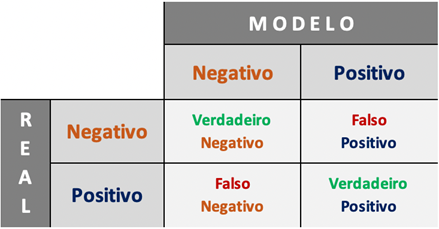

### Fazendo as previsões para os dados de teste

In [231]:
# Visualizando X_train
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare
6,1,54.000000,0,0,51.8625
718,3,29.699118,0,0,15.5000
685,2,25.000000,1,2,41.5792


In [232]:
# Visualizando base teste com dados numéricos
teste_nr.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,892,3,34.5,0,0,7.8292
1,893,3,47.0,1,0,7.0000
2,894,2,62.0,0,0,9.6875


In [233]:
# Excluindo coluna PassengerId para a base de teste ser igual a base de treino
X_teste = teste_nr.drop(["PassengerId"], axis=1)
#Utilizando a Regressão Logística na base de teste
y_pred = clf_rl.predict(X_teste)

In [234]:
# Criação de uma nova coluna com a previsão na base de teste
teste["Survived"] = y_pred
teste

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,male,34.50000,0,0,7.8292,Q,0
1,893,3,female,47.00000,1,0,7.0000,S,0
2,894,2,male,62.00000,0,0,9.6875,Q,0
3,895,3,male,27.00000,0,0,8.6625,S,0
4,896,3,female,22.00000,1,1,12.2875,S,0
...,...,...,...,...,...,...,...,...,...
413,1305,3,male,30.27259,0,0,8.0500,S,0
414,1306,1,female,39.00000,0,0,108.9000,C,1
415,1307,3,male,38.50000,0,0,7.2500,S,0
416,1308,3,male,30.27259,0,0,8.0500,S,0


In [236]:
# Criando base em csv para submissão na competição Kaggle
base_envio = teste[["PassengerId","Survived"]]
base_envio.to_csv("resultados1.csv", index=False)

## Conseguimos pontuação de 0.66746 na competição Kaggle.
* O objetivo, agora, é melhorar a acurácia adicionando novas variáveis à análise.

![resultados1.png](resultados1.png)